Hasta ahora, hemos examinado detenidamente cómo un modelo lineal puede aprender y cómo hacerlo realidad en PyTorch. Nos hemos centrado en un problema de regresión muy sencillo, que solo nos requería utilizar un modelo lineal con una entrada y una salida. Este ejemplo tan simple nos permitió desentrañar la mecánica de un modelo que aprende, sin distraernos demasiado con la implementación del modelo en sí.

Backpropagation del error a los parámetros y luego la actualización de esos parámetros tomando la gradiente con respecto al loss será la misma, sin importar cuál sea el modelo usado.

# Neural Networks

* El uso de funciones de activacion no lineares como la diferencia clave entre modelos lineales
* Los diferentes tipos de funciones de activacion
* El modulo `nn` de PyTorch que contiene los bloques para construir NNs
* Resolver un problema simple de un _fit_ lineal con una NN

## Neuronas artificiales

* Neural networks: entidades matematicas capaces de representar funciones complicadas a traves de una composicion de funciones mas simples.
* Originalmente inspiradas por la forma en la que funciona nuestro cerebro.
* El bloque de construccion basico es una neurona:
    * Esencialmente una transformacion linear del input (e.g. multiplicacion del input por un numero, el _weight_, y la suma de una constante, el _bias_.
    * Seguido por la aplicacion de una funcion no lineal (referida como la funcion de activacion)
    * $o = f(w x + b)$
    * x es nuestro input, w el _weight_ y b el _bias_. $f$ es la funcion de activacion.
    * x puede ser un escalar o un vector de valores, w puede ser un escalar o una matriz, mientras que b es un escalar o un vector.
* La expresion $o = f(w x + b)$ es una capa de neuronas, ya que representa varias neuronas a traves de los _weights_ y _bias_ multidimensionales

$x_1 = f(w_0 x_0 + b_0)$

$x_2 = f(w_1 x_1 + b_1)$

$...$

$y = f(w_n x_n + b_n)$

## Funciones de activacion

* Nuestro modelo anterior ya tenia una operacion lineal. Eso era el modelo entero.
* El rol de la funcion de activacion es concentrar los _outputs_ de la operacion lineal precedente a un rango dado.
* Si queremos asignar un _score_ al output del modelo necesitamos limitar el rango de numeros posibles para ese _score_. De lo contrario tenemos todo el rango de posibles valores de tipo `float32`.


### Que opciones tenemos?

* Una opcion seria ponerle un limite a los valores del _output_.
    * Cualquier cosa debajo de cero seria cero
    * cualquier cosa arriba de 10 seria 10
    * Esta funcion simple de activacion se llama `torch.nn.Hardtanh`
    * Otras funciones son `torch.nn.Sigmoid`: 1 / (1 * e ** -x)

Estas funciones tienen una curva que se aproxima asintóticamente a cero o a menos uno cuando x tiende a menos infinito, y se aproxima a uno cuando x aumenta, teniendo además una pendiente mayormente constante cuando x es igual a 0. Conceptualmente, funciones con esta forma funcionan bien porque significa que hay un área en el medio de la salida de nuestra función lineal a la que nuestra neurona (que de nuevo, es simplemente una función lineal seguida de una activación) será sensible, mientras que todo lo demás se agrupa cerca de los valores límite.

In [7]:
import torch.nn

torch.nn.Hardtanh(-2.2)

Hardtanh(min_val=-2.2, max_val=1.0)

In [8]:
torch.nn.Hardtanh(0.1)

Hardtanh(min_val=0.1, max_val=1.0)

* Hay muchas funciones de activacion.
* Por definicion, las funciones de activacion:
    * Son no lineales. Aplicaciones repetidas de $wx+b$ sin una funcion de activacion resultan en una polinomial. La no linealidad permite a la red aproximar funciones mas complejas.
    * Son diferenciables, para poder calcular las gradientes a traves de ellas. Discontinuidades de punto como en `Hatdtanh` o `ReLU` son validas.
* Sin esto, las redes caen a ser polinomiales complicadas o dificiles de entrenar.
* Adicionalmente, las funciones:
    * Tienen al menos un rango sensible, donde cambios no triviales en el input resultan en cambio no trivial correspondiente en el output
    * Tienen al menos un rango no sensible (o saturado), donde cambios al input resultan en poco o ningun cambio en el output.
* Por utlimo, las fuciones de activacion tienen al menos una de estas:
    * Un limite inferior que se aproxima (o se encuentra) mientras el input tiende a negativo infinito.
    * Un limite superior similar pero inverso para positivo infinito.
* Dado lo que sabemos de como funciona back-propagation
    * Sabemos que los errores se van a propagar hacia atras a traves de la activacion de manera mas efectiva cuando los inputs se encuentran dentro del rango de respuesta.
    * Por otro lado, los errores no van a afectar a las neuornas para cuales el _input_ esta saturado debido a que la gradiente estara cercana a cero.

### En conclusion

* En una red hecha de unidades lineales + activaciones, cuando recibe diferentes _inputs_:
    * diferentes unidades van a responder en diferentes rangos para los mismos inputs
    * los errores asociados a esos inputs van a afectar a las neuronas operancio en el rango sensible, dejando a las otras unidades mas o menos igual en el proceso de aprendizaje.
* Juntar muchas operaciones lineales + unidades de activacion en paralelo y apilandolas una sobre otra nos provee un objeto matematico capaz de aproximar funciones complicadas.
* Diferentes combinaciones de unidades van a responder a inputs en diferentes rangos
    * Esos parametros son relativamente faciles de optimizar a traves de SGD

## Aprendizaje para Neural Networks

* Una red entrenada exitosamente, a traves de los valores de sus _weights_ y _biases_, va a capturar la estructura inherente de la data.
* Esta estrcutura se captura en la forma de representaciones numericas significativas que funcionan de forma correcta para data que no ha visto anteriormente.
* Los NNs nos proveen la habilidad de aproximar fenomenos altamente no lineales sin tener que tener un modelo explicito.
    * En vez empezamos con un model generico, no entrenado y lo especializamos a una tarea al proveerle:
        * un set de inputs
        * un set de outputs
        * una _loss function_ desde la cual puede realizar el back-propagation
    * Especializar un modelo generico a una tarea especifica, usando ejemplos es a lo que nos referimos por _aprendizaje_
    * El modelo no se construyo con esa tarea especifica en mente. No codificamos en el modelo reglas que describen como funciona la tarea.
    
    
* Para nuestro modelo del termometro asumimos que las temperaturas se median de forma lineal.
    * En esa suposicion implicitamente codificamos reglas para nuestra tarea: especificamos la forma de nuestra funcion input/output.
    * No hubiesemos podido aproximar nada mas que no fueran puntos al rededor de una linea.
* Mientras la dimensionalidad de un problema crece y las relaciones entre inputs/outputs se complican, asumir la forma de la funcion probablemente no va a funcionar.
* De cierta forma estamos renunciando la interpretabilidad por la posibilidad de solucionar problemas mas complejos.

## El modulo `nn` de PyTorch

* Vamos a reemplazar nuestro modelo lineal por un NN.
* PyTorch tiene un submodulo entero dedicado a NNs llamado `torch.nn`
* Contiene los bloques necesarios para construir todo tipo de arquitecturas de NNs.
* Esos bloques se llaman _modules_ en PyTorch (en otros frameworks se llaman _layers_)
* Un modulo de PyTorch es una clase de Python que deriva de la clase base `nn.Module`.
    * Un modulo puede tener una o mas instancias de `Parameter` como atributos
    * Estos son tensores cuyos valores son optimizados durante el proceso de entrenamiento ($w$ y $b$)
    * Un modulo tambien puede tener uno o mas submodulos (subclases de `nn.Module` como atributos) y va a poder llevar un registro de sus `Parameter`s de igual forma

In [9]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
#linear_model(val_t_un)

Todas las subclases de `nn.Module` tienen un metodo `call` definido. Esto permite crear una instancia de `nn.Linear` y llamarla como si fuera una funcion.

Llamar una instancia de `nn.Module` con un conjunto de argumetnos termina llamando un metodo llamado `forward` con esos mismos argumentos

### Implementacion de `Module.call`
Este codigo no corre. Solo es para que vean la estructura
(simplificado para claridad).

In [10]:
def __call__(self, *input, **kwargs):
    for hook in self._forward_pre_hooks.values():
        hook(self, input)

    result = self.forward(*input, **kwargs)

    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        pass

    for hook in self._backward_hooks.values():
        pass

    return result

### De regreso al modelo lineal

In [11]:
import torch
import torch.nn as nn

linear_model = nn.Linear(1, 1)
#linear_model(val_t_un)

`nn.Linear` acepta tres argumentos:
* el numero de input features: size del input = 1
* numero de output features: size del outpu = 1
* si incluye un bias o no (por default es `True`)

In [12]:
linear_model.weight

Parameter containing:
tensor([[0.7138]], requires_grad=True)

In [13]:
linear_model.bias

Parameter containing:
tensor([-0.1379], requires_grad=True)

In [14]:
x = torch.ones(1)
x

tensor([1.])

* Nuestro modelo toma un input y produce un output
* `nn.Module` y sus subclases estan diseniados para hacer eso sobre multiples muestras al mismo tiempo
* Para acomodar multiples muestras los modulos esperan que la dimension 0 del input sea el numero de muestras en un _batch_
* Cualquier module en `nn` esta hecho para producir outputs para un _batch_ de multiples inputs al mismo tiempo.
* B x Nin
    * B es el tamanio del _batch_
    * Nin el numero de input features

In [15]:
x = torch.ones(10, 1)
x

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [16]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # Temperatura en grados celsios
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # Unidades desconocidas
t_c = torch.tensor(t_c).unsqueeze(1) # Agregamos una dimension para tener B x N_inputs
t_u = torch.tensor(t_u).unsqueeze(1) # Agregamos una dimension para tener B x N_inputs

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [17]:
import torch.nn as nn
import torch.optim as optim

# Lo que vimos la clase pasada
# solo para que se recuerden
params_old = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate_old = 1e-1
optimizer_old = optim.Adam([params_old], lr=learning_rate_old)


linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(), # reemplazamos [params] con este metodo
    lr=1e-2)

In [18]:
linear_model.parameters()

<generator object Module.parameters at 0x000001E3AF15E430>

In [19]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.2704]], requires_grad=True),
 Parameter containing:
 tensor([-0.8441], requires_grad=True)]

In [20]:
linear_model.weight

Parameter containing:
tensor([[0.2704]], requires_grad=True)

In [21]:
linear_model.bias

Parameter containing:
tensor([-0.8441], requires_grad=True)

In [22]:
x = torch.ones(1)
linear_model(x)

tensor([-0.5737], grad_fn=<AddBackward0>)

In [23]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737],
        [-0.5737]], grad_fn=<AddmmBackward0>)

In [24]:
def training_loop(model, n_epochs, optimizer, loss_fn, train_x, val_x, train_y, val_y):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_x) # ya no tenemos que pasar los params
        train_loss = loss_fn(train_t_p, train_y)

        with torch.no_grad(): # todos los args requires_grad=False
            val_t_p = model(val_x)
            val_loss = loss_fn(val_t_p, val_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss}, Validation loss {val_loss}")

In [25]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(), # Ya no estamos usando nuestra loss function hecha a mano
    train_x = train_t_un,
    val_x = val_t_un,
    train_y = train_t_c,
    val_y = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 230.48114013671875, Validation loss 853.900146484375
Epoch 1000, Training loss 4.057246685028076, Validation loss 14.390748977661133
Epoch 2000, Training loss 3.025770664215088, Validation loss 6.752695560455322
Epoch 3000, Training loss 2.9751224517822266, Validation loss 5.470023155212402

Parameter containing:
tensor([[5.0043]], requires_grad=True)
Parameter containing:
tensor([-15.8237], requires_grad=True)


## Finalmente un Neural Network

* Ultimo paso: reemplazar nuestro modelo lineal
* No va a ser mejor
* Lo unico que vamos a cambiar va a ser el modelo
* Un simple NN:
    * Una capa lineal
    * Activacion
    * "hidden layers"

In [26]:
seq_model = nn.Sequential(
                nn.Linear(1, 13), # El 13 es arbitrario
                nn.Tanh(),
                nn.Linear(13, 1) # Este 13 debe hacer match con el primero
            )

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

* El resultado final es un modelo que toma los inputs esperados por el primer modulo (_layer_)
* Pasa los outputs intermedios al resto de los modulos
* Produce un output retornado por el ultimo modulo

In [27]:
[param.size() for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

* Estos son los parametros que el optimizador va a recibir
* Al llamar `backward()` todos los parametros se van a llenar con su `grad`
* El optimizador va a actualizar el valor de `grad` durante `optimizer.step()`

In [28]:
for name, param in seq_model.named_parameters():
    print(name, param.size())

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [29]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
        ('hidden_linear', nn.Linear(1, 8)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [30]:
for name, param in seq_model.named_parameters():
    print(name, param.size())

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Util para inspeccionar parametros o sus gradientes.

In [31]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(), # Ya no estamos usando nuestra loss function hecha a mano
    train_x = train_t_un,
    val_x = val_t_un,
    train_y = train_t_c,
    val_y = val_t_c)

print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 124.70235443115234, Validation loss 527.8956909179688
Epoch 1000, Training loss 5.168014049530029, Validation loss 58.950340270996094
Epoch 2000, Training loss 3.044384002685547, Validation loss 29.229238510131836
Epoch 3000, Training loss 2.4778554439544678, Validation loss 19.35959815979004
Epoch 4000, Training loss 2.2201220989227295, Validation loss 13.993354797363281
Epoch 5000, Training loss 2.0865283012390137, Validation loss 10.809553146362305
output tensor([[13.3169],
        [23.6663]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [28.]])
hidden tensor([[ 0.0011],
        [ 0.0004],
        [ 0.0076],
        [ 0.0002],
        [ 0.0535],
        [ 0.0021],
        [ 0.0179],
        [-0.0102]])


Tambien podemos evaluar el modelo en toda la data y ver que tan diferente es de una linea:

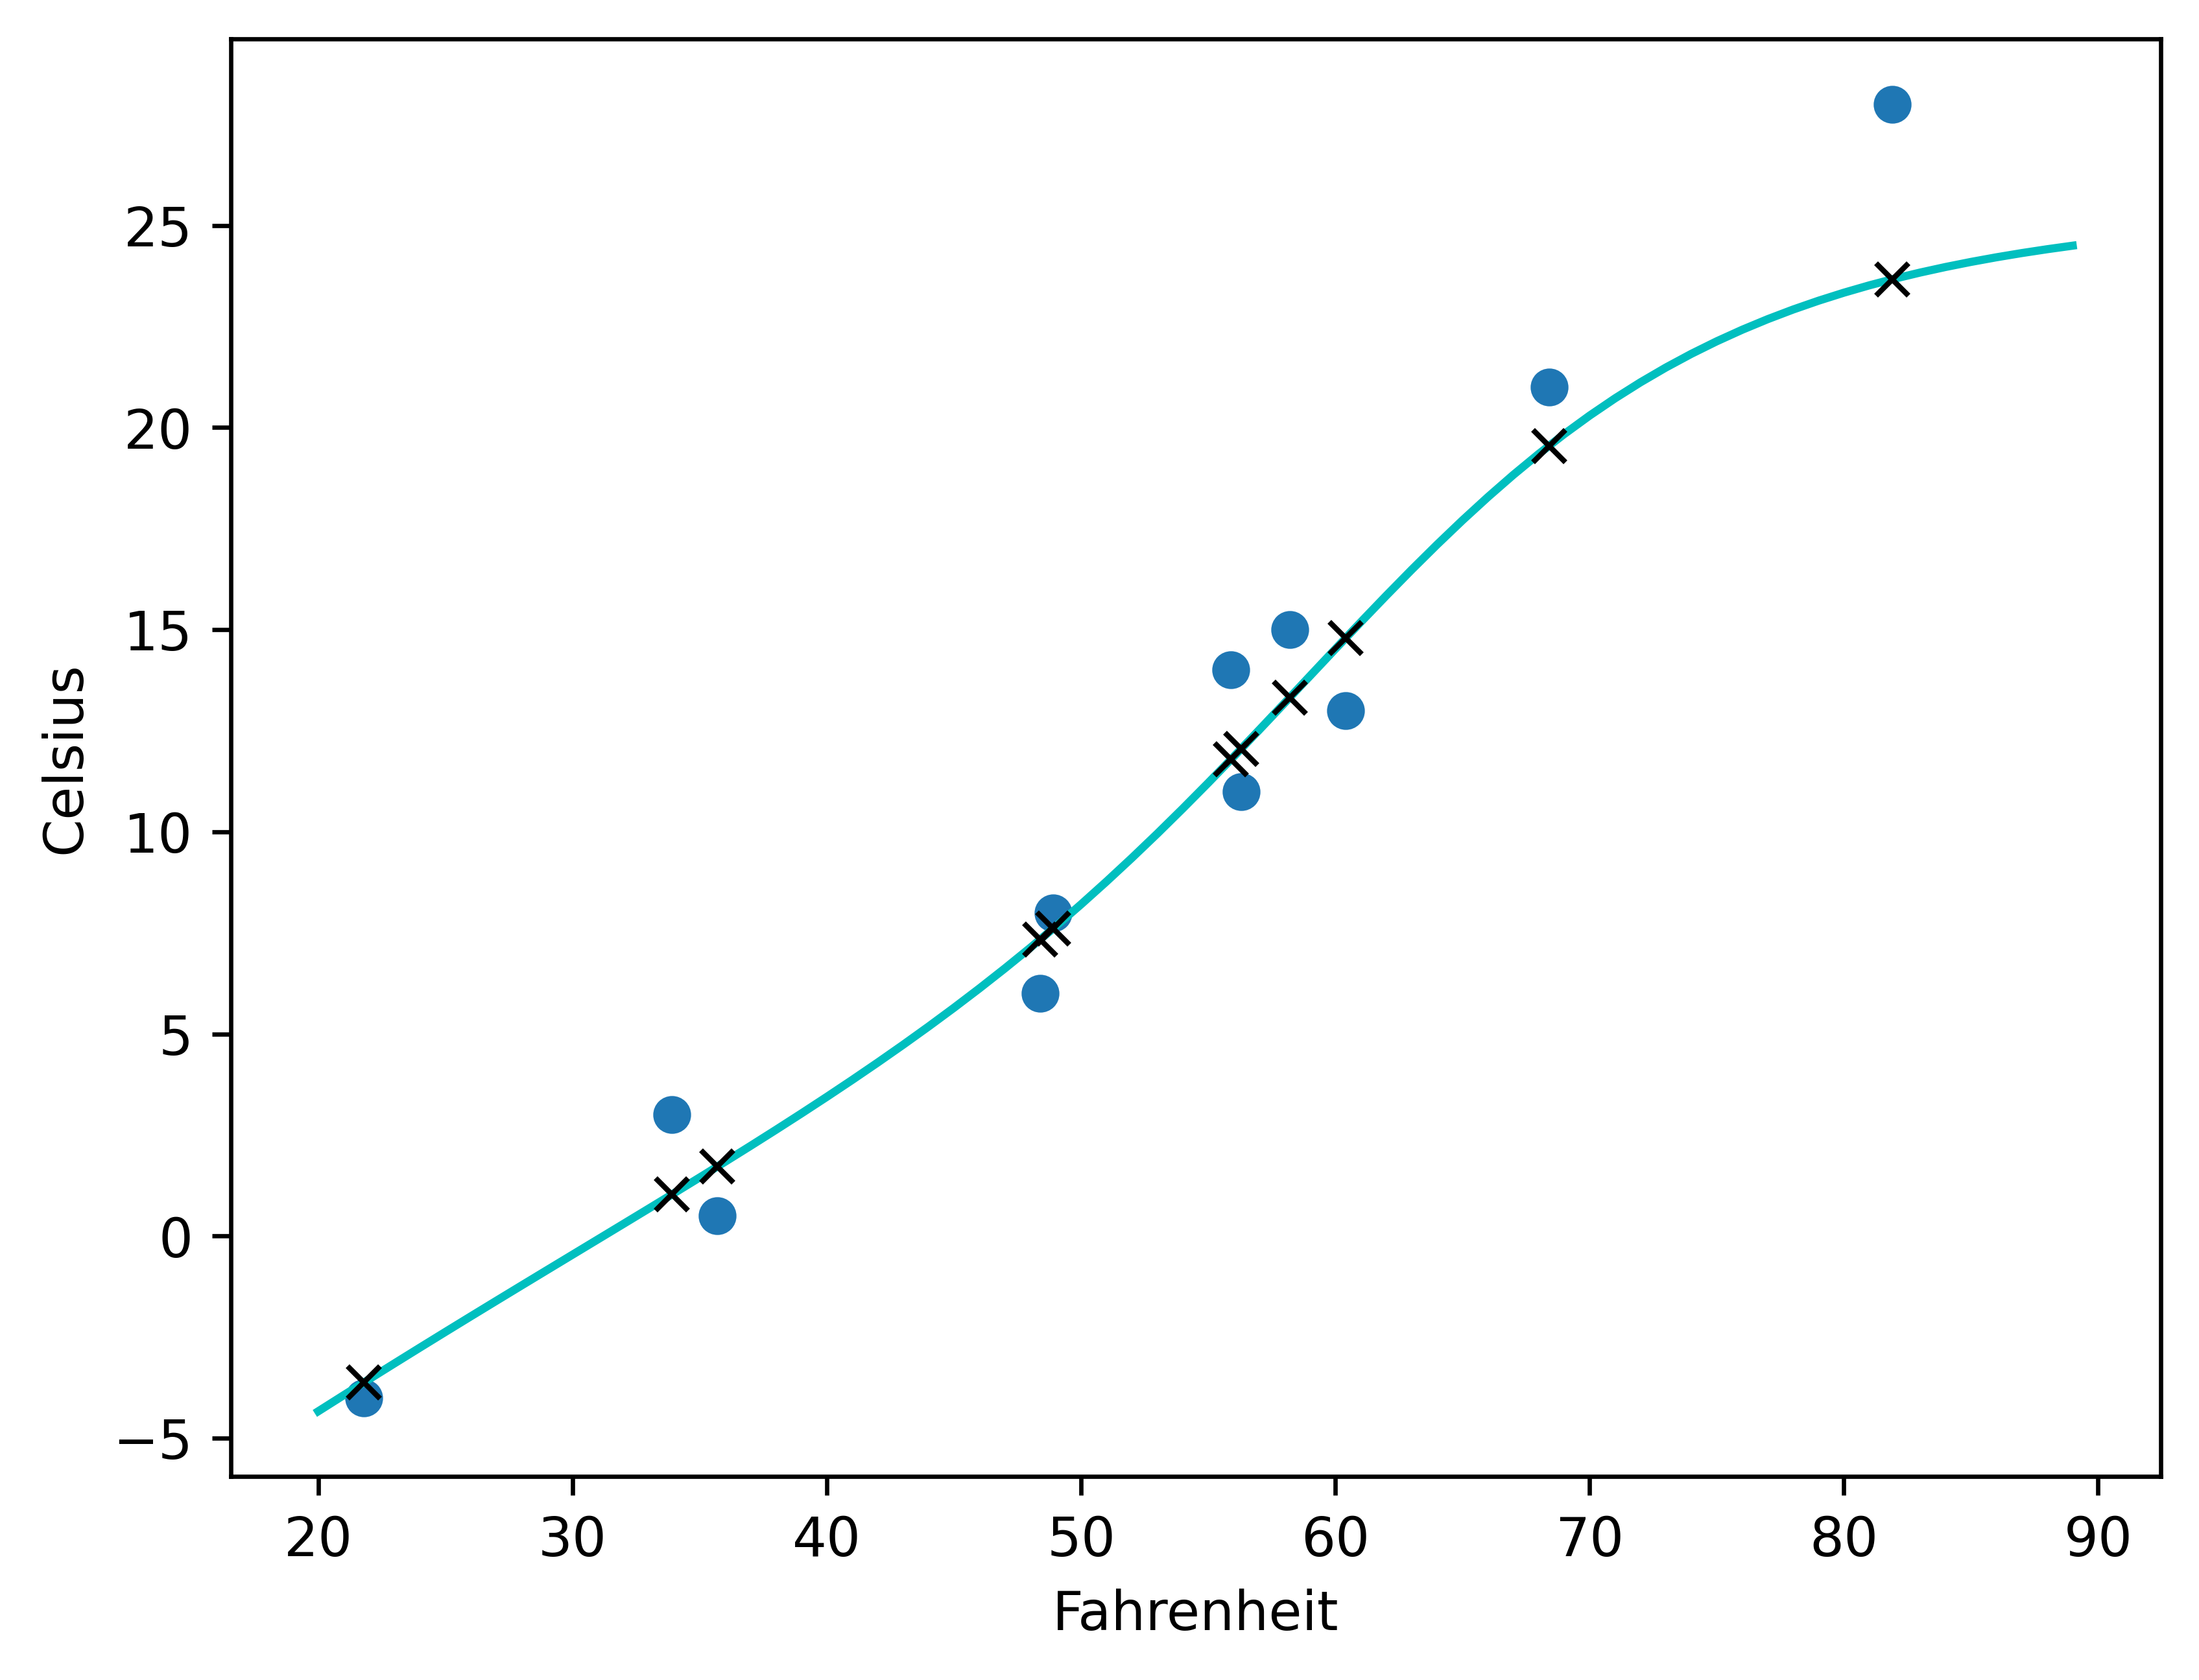

In [32]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()

## Subclassing nn.Module

* sublcassing `nn.Module` nos da mucha mas flexibilidad.
* La interface especifica que como minimo debemos definir un metodo `forward` para la subclase
    * `forward` toma el input al model y regresa el output
* Si usamos las operaciones de `torch`, `autograd` se encarga de hacer el `backward` pass de forma automatica

* Normalmente vamos a definir los submodulos que usamos en el metodo `forward` en el constructor
    * Esto permite que sean llamados en `forward` y que puedan mantener sus parametros a durante la existencia de nuestro modulo

In [33]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)


    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        #activated_t = self.hidden_activation(hidden_t) if random.random() > 0.5 else hidden_t
        output_t = self.output_linear(activated_t)

        return output_t


subclass_model = SubclassModel()
subclass_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

* Nos permite manipular los outputs de forma directa  y transformarlo en un tensor BxN
* Dejamos la dimension de batch como -1 ya que no sabemos cuantos inputs van a venir por batch

* Asignar una instancia de `nn.Module` a un atributo en un `nn.Module` registra el modulo como un submodulo.
* Permite a `Net` acceso a los `parameters` de sus submodulos sin necesidad de hacerlo manualmente

In [34]:
numel_list = [p.numel() for p in subclass_model.parameters()]
sum(numel_list), numel_list

(40, [13, 13, 13, 1])

**Lo que paso**

* `parameters()` investiga todos los submodulos asignados como atributos del constructor y llama `parameters` de forma recursiva.
* Al accesar su atributo `grad`, el cual va a ser llenado por el `autograd`, el optimizador va a saber como cambiar los parametros para minimizar el _loss_

In [35]:
for type_str, model in [('seq', seq_model), ('named_seq', named_seq_model), ('subclass', subclass_model)]:
    print(type_str)
    for name_str, param in model.named_parameters():
        print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))

    print()

NameError: name 'named_seq_model' is not defined

In [36]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 14)
        self.output_linear = nn.Linear(14, 1)


    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t)
        output_t = self.output_linear(activated_t)

        return output_t


func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)

## Ejercicios

* Experimenten con el numero de neuronas en el modelo al igual que el learning rate.
    * Que cambios resultan en un output mas lineal del modelo?
    * Pueden hacer que el modelo haga un overfit obvio de la data?
    
* Cargen la [data de vinos blancos](https://archive.ics.uci.edu/ml/datasets/wine+quality) y creen un modelo con el numero apropiado de inputs
    * Cuanto tarda en entrenar comparado al dataset que hemos estado usando?
    * Pueden explicar que factores contribuyen a los tiempos de entrenamiento?
    * Pueden hacer que el _loss_ disminuya?
    * Intenten graficar la data